In [2]:
from src.data_gen import data_gen, data_gen_xu
from src.csc_ipca import CSC_IPCA
from src.csc_ife import CSC_IFE
from src.scm import SCM
from joblib import Parallel, delayed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the global font to be Times New Roman
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 8 
color = sns.color_palette()
color

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [3]:
# number of time periods and individuals
T0, T1 = 20, 10
N_co, N_tr = 45, 5

# number of covariates and time-varying factors
L, K = 9, 2
# drift and ratio of observing covariates
drift = 2
# similarity parameter between treated and untreated
w = 0.7

In [4]:
# define a function to gen simulated true and estimated ATT
def simulation_fun(data, method, alpha):
    # gen data
    if data == 'IPCA_data':
        df = data_gen(T0, T1, N_co, N_tr, L, K, drift)
    elif data == 'IFE_data':
        df = data_gen_xu(T0, T1, N_co, N_tr, L, K, w)
    else:
        raise ValueError('data should be either IPCA_data or IFE_data')
    # add constant
    df['const'] = 1
    # compute true ATT
    ATT = df.query("tr_group==1").groupby('time')['eff'].mean()[-T1:].mean()

    # define covariates and observed covariates
    covariates = ['x'+str(i) for i in range(1, L+1)]
    L_obs = round(L*alpha)
    obs_covariates = list(np.random.choice(covariates, size=L_obs, replace=False)) + ['const']

    if method == 'CSC_IPCA':
        model = CSC_IPCA()
    elif method == 'CSC_IFE':
        model = CSC_IFE()
    elif method == 'SCM':
        model = SCM()
    else:
        raise ValueError('method should be either CSC_IPCA, CSC_IFE or SCM')
    # fit model
    if method in ['CSC_IPCA', 'CSC_IFE']:
        model.fit(df, 'id', 'time', 'y', 'treated', obs_covariates, K)
        y_syn = model.predict()
        att_est = (df.query("tr_group==1").groupby('time')['y'].mean()[-T1:] - y_syn.mean(axis=0)[-T1:]).mean()
    elif method == 'SCM':
        model.fit(df, 'id', 'time', 'y', 'treated', None)
        y_syn = model.predict()
        att_est = (df.query("tr_group==1").groupby('time')['y'].mean()[-T1:] - y_syn[-T1:]).mean()
    
    # compute bias
    bias = att_est - ATT

    return bias

# define a function to run simulation
def simulate(n_repeat, data, method, alpha):
    bias = np.zeros(n_repeat)
    for i in range(n_repeat):
        bias[i] = simulation_fun(data, method, alpha)
    return {'data': data, 'method': method, 'alpha': alpha, 'bias': bias}

In [5]:
# use joblib to run simulations in parallel
n_repeat = 1000
alpha_list = [0.3, 0.6, 1]
methods_list = ['CSC_IPCA', 'CSC_IFE', 'SCM']

### 1. My data generating process

In [6]:
# Use joblib to run simulations in parallel
# n_jobs=-1 uses all available CPU cores
result1 = Parallel(n_jobs=-1)(delayed(simulate)(n_repeat, 'IPCA_data', method, alpha) for alpha in alpha_list for method in methods_list)
df_result1 = pd.DataFrame(result1)

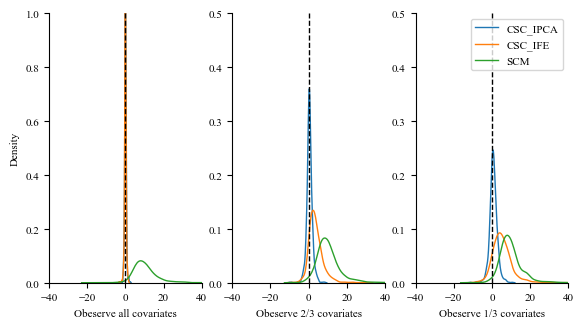

In [13]:
# plot
fig, ax = plt.subplots(1, 3, figsize=(6.7, 3.5))

sns.kdeplot(df_result1.query("method=='CSC_IPCA' & alpha==1")['bias'].values[0], label='CSC_IPCA', ax=ax[0], linewidth=1)
sns.kdeplot(df_result1.query("method=='CSC_IFE' & alpha==1")['bias'].values[0], label='CSC_IFE', ax=ax[0], linewidth=1)
sns.kdeplot(df_result1.query("method=='SCM' & alpha==1")['bias'].values[0], label='SCM', ax=ax[0], linewidth=1)

sns.kdeplot(df_result1.query("method=='CSC_IPCA' & alpha==0.6")['bias'].values[0], label='CSC_IPCA', ax=ax[1], linewidth=1)
sns.kdeplot(df_result1.query("method=='CSC_IFE' & alpha==0.6")['bias'].values[0], label='CSC_IFE', ax=ax[1], linewidth=1)
sns.kdeplot(df_result1.query("method=='SCM' & alpha==0.6")['bias'].values[0], label='SCM', ax=ax[1], linewidth=1)

sns.kdeplot(df_result1.query("method=='CSC_IPCA' & alpha==0.3")['bias'].values[0], label='CSC_IPCA', ax=ax[2], linewidth=1)
sns.kdeplot(df_result1.query("method=='CSC_IFE' & alpha==0.3")['bias'].values[0], label='CSC_IFE', ax=ax[2], linewidth=1)
sns.kdeplot(df_result1.query("method=='SCM' & alpha==0.3")['bias'].values[0], label='SCM', ax=ax[2], linewidth=1)

for i in range(3):
    ax[i].axvline(0, color='black', linestyle='--', linewidth=1)
ax[0].set(xlabel='Obeserve all covariates', ylabel='Density', ylim=(0, 1), xlim=(-40, 40))
ax[1].set(xlabel='Obeserve 2/3 covariates', ylabel='', ylim=(0, 0.5), xlim=(-40, 40))
ax[2].set(xlabel='Obeserve 1/3 covariates', ylabel='', ylim=(0, 0.5), xlim=(-40, 40))

plt.legend()
sns.despine()
# save the plot
#plt.savefig('figs/bias_compar1.png', dpi=300)

### 2. Xu's data

In [9]:
# Use joblib to run simulations in parallel
# n_jobs=-1 uses all available CPU cores
result2 = Parallel(n_jobs=-1)(delayed(simulate)(n_repeat, 'IFE_data', method, alpha) for alpha in alpha_list for method in methods_list)
df_result2 = pd.DataFrame(result2)

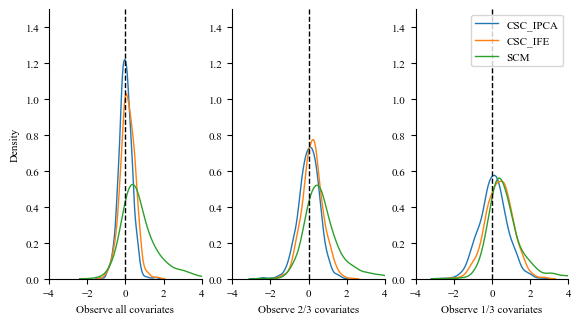

In [12]:
# plot
fig, ax = plt.subplots(1, 3, figsize=(6.7, 3.5))

sns.kdeplot(df_result2.query("method=='CSC_IPCA' & alpha==1")['bias'].values[0], label='CSC_IPCA', ax=ax[0], linewidth=1)
sns.kdeplot(df_result2.query("method=='CSC_IFE' & alpha==1")['bias'].values[0], label='CSC_IFE', ax=ax[0], linewidth=1)
sns.kdeplot(df_result2.query("method=='SCM' & alpha==1")['bias'].values[0], label='SCM', ax=ax[0], linewidth=1)

sns.kdeplot(df_result2.query("method=='CSC_IPCA' & alpha==0.6")['bias'].values[0], label='CSC_IPCA', ax=ax[1], linewidth=1)
sns.kdeplot(df_result2.query("method=='CSC_IFE' & alpha==0.6")['bias'].values[0], label='CSC_IFE', ax=ax[1], linewidth=1)
sns.kdeplot(df_result2.query("method=='SCM' & alpha==0.6")['bias'].values[0], label='SCM', ax=ax[1], linewidth=1)

sns.kdeplot(df_result2.query("method=='CSC_IPCA' & alpha==0.3")['bias'].values[0], label='CSC_IPCA', ax=ax[2], linewidth=1)
sns.kdeplot(df_result2.query("method=='CSC_IFE' & alpha==0.3")['bias'].values[0], label='CSC_IFE', ax=ax[2], linewidth=1)
sns.kdeplot(df_result2.query("method=='SCM' & alpha==0.3")['bias'].values[0], label='SCM', ax=ax[2], linewidth=1)

for i in range(3):
    ax[i].set(xlim=(-4, 4), ylim=(0, 1.5))
    ax[i].axvline(0, color='black', linestyle='--', linewidth=1)
ax[0].set(ylabel='Density', xlabel='Observe all covariates')
ax[1].set(ylabel='', xlabel='Observe 2/3 covariates')
ax[2].set(ylabel='', xlabel='Observe 1/3 covariates')

plt.legend()
sns.despine()
# save the plot
#plt.savefig('figs/bias_compar2.png', dpi=300)